In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PREPROCESSING DATA

In [3]:
df = pd.read_csv('ecommerce_customer_data_large.csv')
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [5]:
newdata= df.groupby('Payment Method').size().rename_axis('PaymentMethodCategory').reset_index(name='Count')
newdata.head

<bound method NDFrame.head of   PaymentMethodCategory  Count
0                  Cash  83012
1           Credit Card  83547
2                PayPal  83441>

In [34]:
labels=newdata.PaymentMethodCategory
values= newdata.Count

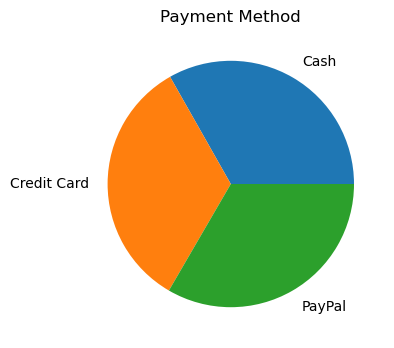

In [35]:
plt.figure(figsize=(5,4))
plt.pie(values,labels=labels, labeldistance=1.15 );
plt.title("Payment Method")
plt.show();


In [3]:
missing_values = df.isnull().sum()
print("Missing Values: \n", missing_values)

Missing Values: 
 Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64


In [4]:
df['Customer Age'].fillna(df['Customer Age'].median(),inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

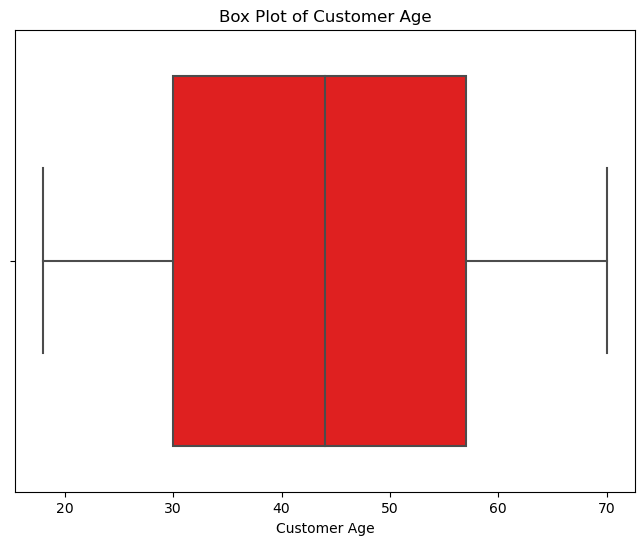

In [8]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['Customer Age'],color='red')
plt.title('Box Plot of Customer Age')
plt.xlabel('Customer Age')
plt.show()

In [8]:
df=df[df['Customer Age'] <= 100]

# EXPLORATORY DATA ANALYSIS [EDA]

In [9]:
basic_stats=df[['Total Purchase Amount']].describe()
print("Basic Statistics of Total Purchase Amount:\n", basic_stats)

Basic Statistics of Total Purchase Amount:
        Total Purchase Amount
count          250000.000000
mean             2725.385196
std              1442.576095
min               100.000000
25%              1476.000000
50%              2725.000000
75%              3975.000000
max              5350.000000


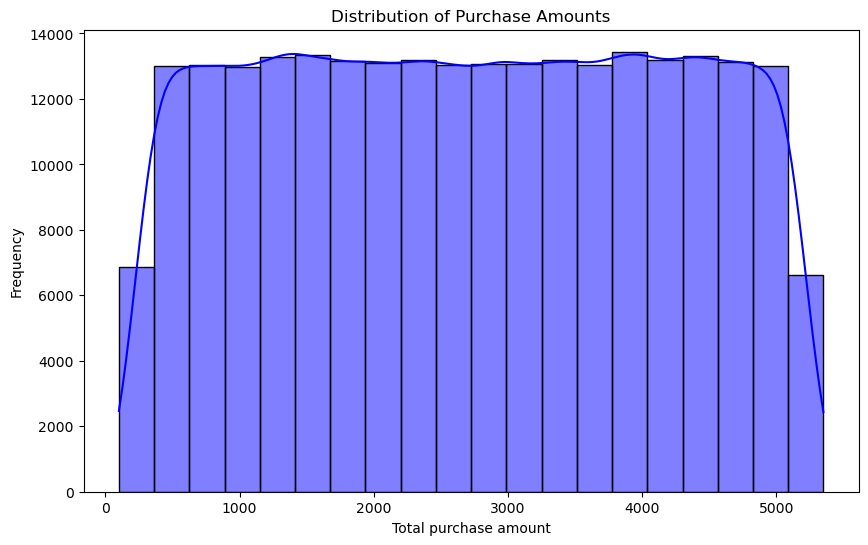

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(df['Total Purchase Amount'],bins=20, kde=True , color='blue')
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Total purchase amount')
plt.ylabel('Frequency')
plt.show()

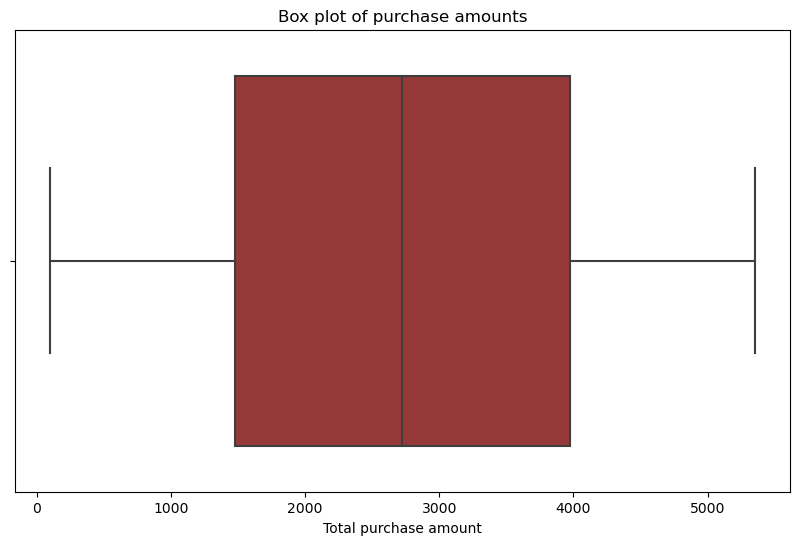

In [14]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['Total Purchase Amount'],color='brown')
plt.title('Box plot of purchase amounts')
plt.xlabel('Total purchase amount')
plt.show()

C:\Users\sange\AppData\Local\Temp\ipykernel_9952\564608645.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Month',y='Total Purchase Amount',data=df,estimator=sum,ci=None)


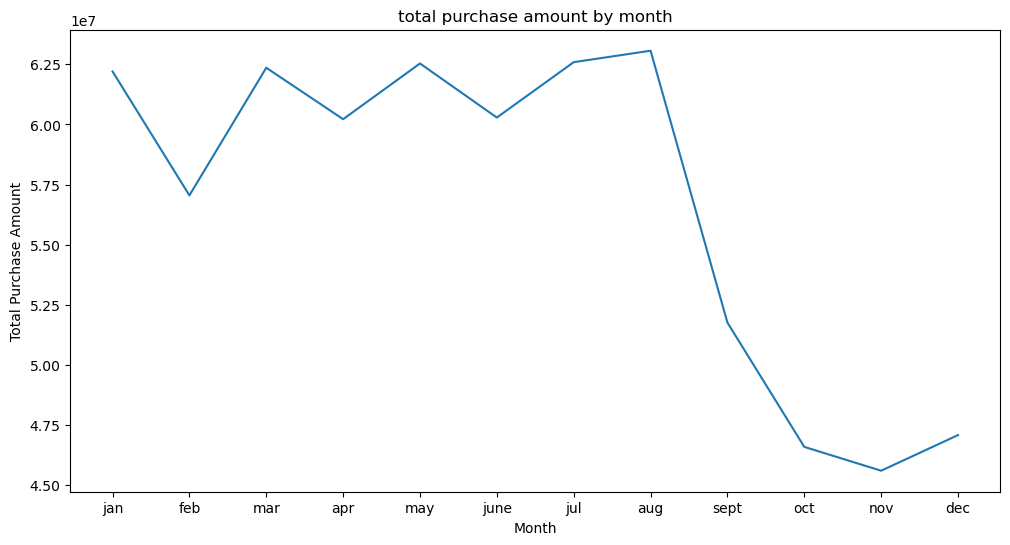

In [23]:
df['Purchase Date']=pd.to_datetime(df['Purchase Date'])
df['Month']=df['Purchase Date'].dt.month

plt.figure(figsize=(12,6))
sns.lineplot(x='Month',y='Total Purchase Amount',data=df,estimator=sum,ci=None)
plt.title('total purchase amount by month')
plt.xlabel('Month')
plt.ylabel('Total Purchase Amount')
plt.xticks(range(1,13),['jan','feb','mar','apr','may','june','jul','aug','sept','oct','nov','dec'])
plt.show()

In [33]:
top_products = df['Product Category'].value_counts().nlargest(5)
print("Top 5 selling products:\n", top_products)



Top 5 selling products:
 Product Category
Electronics    62630
Clothing       62581
Home           62542
Books          62247
Name: count, dtype: int64


# RFM ANALYSIS

In [6]:
df_recency = df.groupby(by='Customer Name', as_index=False)['Quantity'].max()
df_recency.columns = ['CustomerName', 'Purchase Date']
recent_date = df_recency['Purchase Date'].max()
df_recency['Recency'] = df_recency['Purchase Date'].apply(
    lambda x: (recent_date - x))
df_recency.head()


,CustomerName,Purchase Date,Recency
0,Aaron Alexander,5,0
1,Aaron Archer,4,1
2,Aaron Armstrong,5,0
3,Aaron Avery,4,1
4,Aaron Avila,5,0


In [7]:
frequency_df = df.drop_duplicates().groupby(by=['Customer Name'], as_index=False)['Purchase Date'].count()
frequency_df.columns = ['CustomerName', 'Frequency']
frequency_df.head()


,CustomerName,Frequency
0,Aaron Alexander,5
1,Aaron Archer,4
2,Aaron Armstrong,3
3,Aaron Avery,6
4,Aaron Avila,7


In [8]:
df['Total'] = df['Product Price']*df['Quantity']
monetary_df = df.groupby(by='Customer Name', as_index=False)['Total'].sum()
monetary_df.columns = ['CustomerName', 'Monetary']
monetary_df.head()


,CustomerName,Monetary
0,Aaron Alexander,1960
1,Aaron Archer,2135
2,Aaron Armstrong,3626
3,Aaron Avery,5305
4,Aaron Avila,5210


In [9]:
rf_df = df_recency.merge(frequency_df, on='CustomerName')
rfm_df = rf_df.merge(monetary_df, on='CustomerName').drop(columns='Purchase Date')
rfm_df.head()


,CustomerName,Recency,Frequency,Monetary
0,Aaron Alexander,0,5,1960
1,Aaron Archer,1,4,2135
2,Aaron Armstrong,0,3,3626
3,Aaron Avery,1,6,5305
4,Aaron Avila,0,7,5210


In [9]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df.head()


,CustomerName,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,Aaron Alexander,0,5,1960,100.000000,45.039872,45.039872
1,Aaron Archer,1,4,2135,32.768008,29.649180,29.649180
2,Aaron Armstrong,0,3,3626,100.000000,15.981243,15.981243
3,Aaron Avery,1,6,5305,32.768008,59.431265,59.431265
4,Aaron Avila,0,7,5210,100.000000,70.989017,70.989017


# VISUALIZATION

C:\Users\sange\anaconda python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sange\anaconda python\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


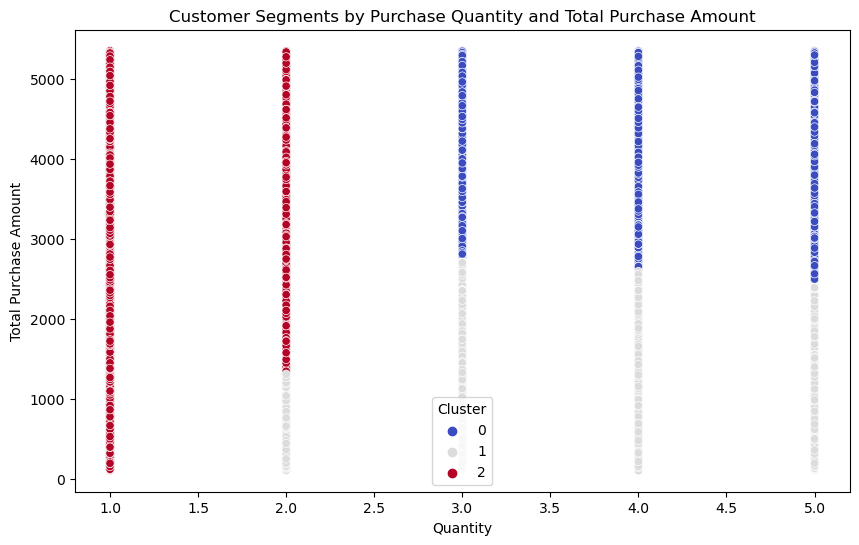

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering
X = df[['Quantity', 'Total Purchase Amount']]  # Features for segmentation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the features

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize customer segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='Total Purchase Amount', hue='Cluster', data=df, palette='coolwarm')
plt.title('Customer Segments by Purchase Quantity and Total Purchase Amount')
plt.xlabel('Quantity')
plt.ylabel('Total Purchase Amount')
plt.legend(title='Cluster')
plt.show()

In [15]:
customer_segment_summary = df.groupby('Cluster').agg({
    'Customer ID': 'size',  # Counting the number of customers in each cluster
    'Total Purchase Amount': 'mean',  # Average purchase amount per cluster
    'Quantity': 'mean'  # Assuming 'Quantity' represents frequency or average purchases
}).rename(columns={'Customer ID': 'Customer Count', 'Total Purchase Amount': 'Avg. Purchase Amount', 'Quantity': 'Avg. Frequency'})
print("Customer Segment Summary:\n", customer_segment_summary)

Customer Segment Summary:
          Customer Count  Avg. Purchase Amount  Avg. Frequency
Cluster                                                      
0                 78955           3911.201381        4.036970
1                 82357           1331.172505        3.703486
2                 88688           2964.392251        1.437477


In [5]:
top_products = df['Product Category'].value_counts().nlargest(5)
print("Top 5 Selling Product Categories:\n", top_products)

Top 5 Selling Product Categories:
 Product Category
Electronics    62630
Clothing       62581
Home           62542
Books          62247
Name: count, dtype: int64


In [10]:
purchase_trend = df.groupby(df['Purchase Date']).agg({'Total Purchase Amount': 'sum'})
print("Purchase Trend Over Time:\n", purchase_trend)

Purchase Trend Over Time:
                      Total Purchase Amount
Purchase Date                             
2020-01-01 00:07:26                   2046
2020-01-01 00:11:40                   2514
2020-01-01 00:15:47                    713
2020-01-01 00:24:27                   4197
2020-01-01 00:28:45                   5150
...                                    ...
2023-09-13 18:02:42                   4492
2023-09-13 18:16:46                   3481
2023-09-13 18:33:30                   4634
2023-09-13 18:37:07                   3998
2023-09-13 18:42:49                   2076

[249728 rows x 1 columns]


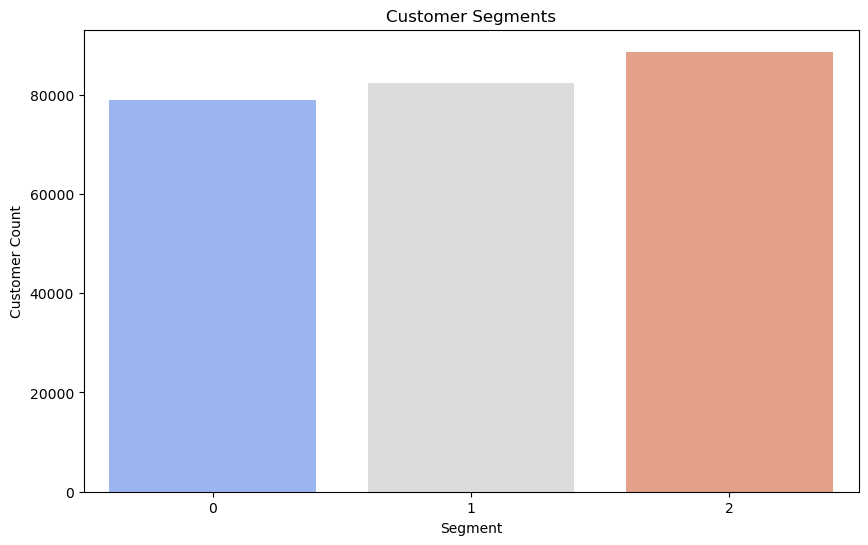

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=df, palette='coolwarm')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Customer Count')
plt.show()

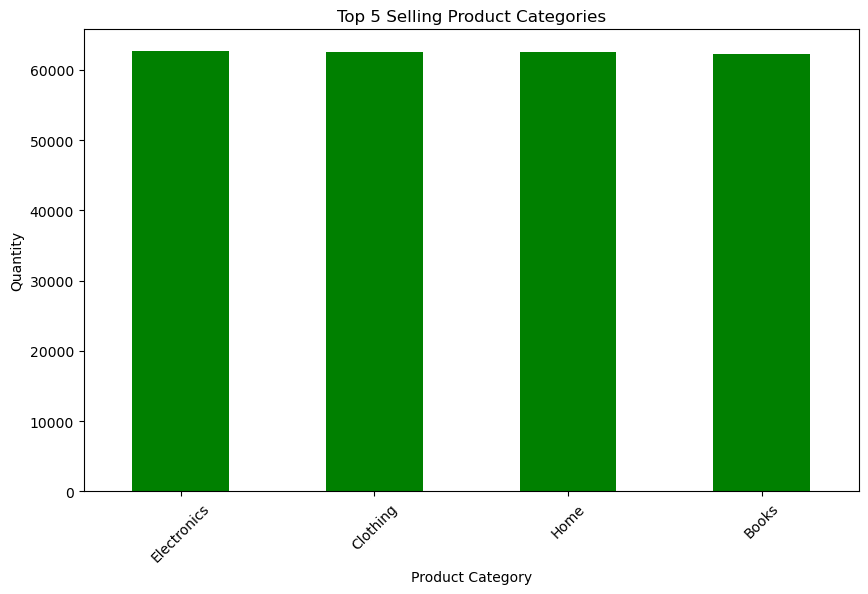

In [6]:
# Visualize top-selling products
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='green')
plt.title('Top 5 Selling Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x600 with 0 Axes>

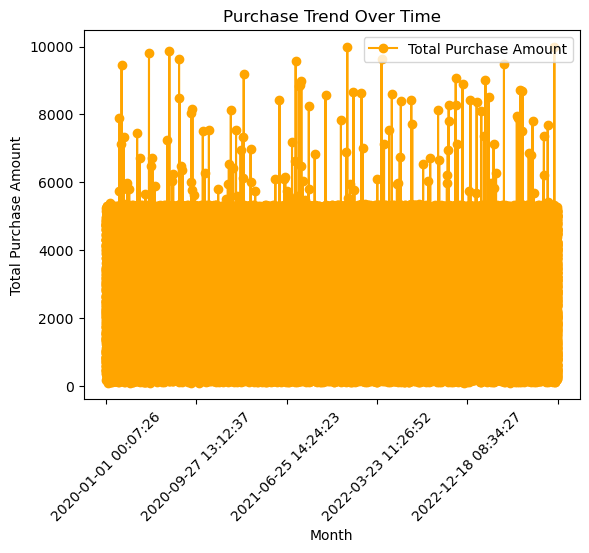

In [29]:
# Visualize purchase trend over time
plt.figure(figsize=(12, 6))
purchase_trend.plot(kind='line', color='orange', marker='o')
plt.title('Purchase Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.show()

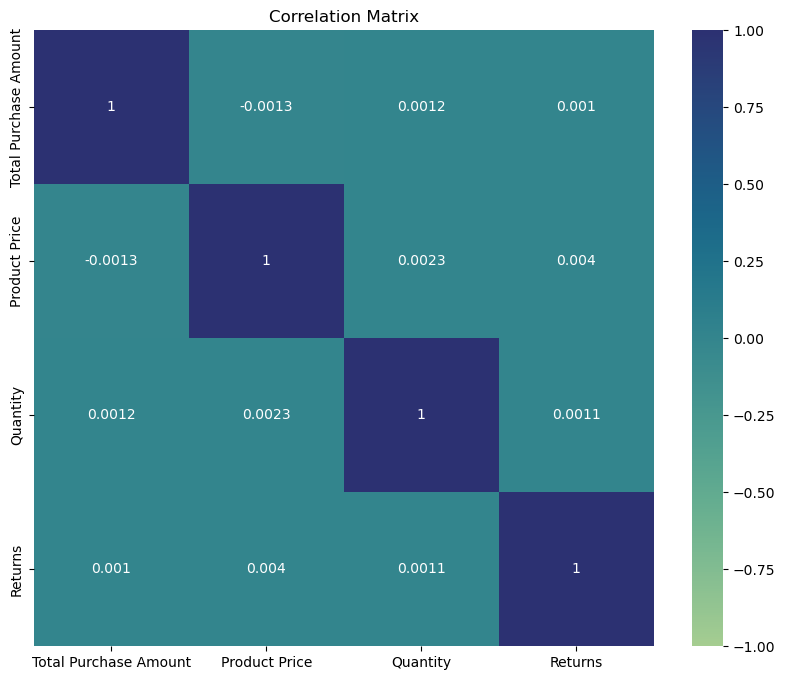

In [17]:
new=['Total Purchase Amount','Product Price','Quantity','Returns']
correlation_matrix = df[new].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='crest',vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()